In [1]:
%load_ext autoreload
%autoreload 2
from models.ddm_ll import Lap_Pyramid_Conv
import matplotlib.pyplot as plt
import torch
import cv2
import numpy as np
from torchvision.transforms.functional import to_pil_image

In [1]:
x=[1,2,3]

In [2]:
x[-2]

2

In [21]:
img = cv2.imread("/datasata/xuronghao/coding/imgs/262A3283.png")
img = torch.from_numpy((img / 255.0).transpose(2, 0, 1).astype(np.float32)).unsqueeze(0)

In [ ]:
x = torch.randn(1, 3, 256, 256).to(torch.device('cuda:1'))

In [22]:
lpm = Lap_Pyramid_Conv(2, in_chans=3)

In [23]:
out = lpm.pyramid_decom(img)

In [ ]:
fig, axes = plt.subplots(len(out), 2, figsize=(10, 5))  # 创建 1 行 2 列的子图
for i in range(len(out)):
    # Step 1: 提取 high_tensor 和 low_tensor，并去掉 batch 维度
    high_tensor = out[i][0].squeeze(0)  # 形状变为 [3, H, W]
    low_tensor = out[i][1].squeeze(0)   # 形状变为 [3, H, W]

    # Step 2: 检查值范围并归一化到 [0, 1]
    if high_tensor.max() > 1:
        high_tensor = high_tensor / 255.0
    if low_tensor.max() > 1:
        low_tensor = low_tensor / 255.0

    # Step 3: 将 Tensor 转换为 PIL 图像
    high_image = to_pil_image(high_tensor)
    low_image = to_pil_image(low_tensor)

    # Step 4: 使用 matplotlib 显示 high 和 low 图像
    axes[i][0].imshow(high_image)
    axes[i][0].set_title(f"High Resolution {high_tensor.shape[1], high_tensor.shape[2]}")
    axes[i][0].axis('off')  # 关闭坐标轴

    axes[i][1].imshow(low_image)
    axes[i][1].set_title(f"Low Resolution {high_tensor.shape[1], high_tensor.shape[2]}")
    axes[i][1].axis('off')  # 关闭坐标轴

plt.tight_layout()  # 自动调整子图间距
plt.show()

In [ ]:
from diffusers import DiffusionPipeline
import torch
import matplotlib.pyplot as plt

# 指定模型路径
model_id = "/datadisk2/xuronghao/hf_home/hub/models--stabilityai--stable-diffusion-2/snapshots/1e128c8891e52218b74cde8f26dbfc701cb99d79"

# 加载模型
pipeline = DiffusionPipeline.from_pretrained(
    model_id,
    use_safetensors=True,
    torch_dtype=torch.float16
)
device = "cuda:0" if torch.cuda.is_available() else "cpu"
pipeline = pipeline.to(device)



In [ ]:
# 输入提示词
prompt = "A gym"

# 生成图像
with torch.autocast("cuda"):
    image = pipeline(prompt, num_inference_steps=25).images[0]

# 使用 matplotlib 显示图像
plt.figure()  # 设置图像大小
plt.imshow(image)             # 显示图像
plt.axis("off")               # 关闭坐标轴
plt.show()

In [ ]:
from diffusers import DDPMScheduler, UNet2DModel

model_path = "/datadisk2/xuronghao/hf_home/hub/models--google--ddpm-cat-256/snapshots/82ca0d5db4a5ec6ff0e9be8d86852490bc18a3d9"
scheduler = DDPMScheduler.from_pretrained(model_path)
model = UNet2DModel.from_pretrained(model_path, use_safetensors=True).to("cuda")

In [ ]:
scheduler.set_timesteps(100)
scheduler.timesteps

In [ ]:
from matplotlib.widgets import Slider
import matplotlib.pyplot as plt
import torch
from PIL import Image
import numpy as np
import ipywidgets as widgets
from IPython.display import display, clear_output

sample_size = model.config.sample_size
noise = torch.randn((1, 3, sample_size, sample_size), device="cuda")
input = noise

# 保存每个时间步生成的图像
images = []

for t in scheduler.timesteps:
    with torch.no_grad():
        noisy_residual = model(input, t).sample
    previous_noisy_sample = scheduler.step(noisy_residual, t, input).prev_sample
    input = previous_noisy_sample

    # 处理图像
    image = (input / 2 + 0.5).clamp(0, 1).squeeze()
    image = (image.permute(1, 2, 0) * 255).round().to(torch.uint8).cpu().numpy()
    images.append(image)

# 创建滑动条
slider = widgets.IntSlider(
    value=0,  # 初始值
    min=0,  # 最小值
    max=len(scheduler.timesteps) - 1,  # 最大值
    step=1,  # 步长
    description='Timestep:',  # 滑动条标签
    continuous_update=False  # 只有在松开滑动条时更新
)

# 更新函数
def update_image(t):
    clear_output(wait=True)  # 清除之前的输出
    plt.figure(figsize=(6, 6))
    plt.imshow(images[t])
    plt.axis('off')  # 关闭坐标轴
    plt.title(f"Timestep: {t}")
    plt.show()

# 绑定滑动条和更新函数
interactive_plot = widgets.interactive(update_image, t=slider)

# 显示滑动条和图像
display(interactive_plot)


In [18]:
from omegaconf import OmegaConf

In [26]:
with open("./configs/ll.yml", "r") as f:
    # namespace
    df = OmegaConf.load(f)

dict_config = OmegaConf.to_container(df, resolve=True)

In [27]:
dict_config["model_name"]

'LL_DDM'

In [2]:
l = [1,2, 2, 2]+ [2,4]

In [3]:
l[:-2]

[1, 2, 2, 2]

In [2]:
from models.ddm_ll import Lap_Pyramid_Conv
from PIL import Image
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim
from omegaconf import OmegaConf
transform = transforms.ToTensor()

In [3]:
lp_config = OmegaConf.load("/datadisk2/xuronghao/Projects/Basic/configs/ll.yml")

In [4]:
LP = Lap_Pyramid_Conv(lp_config.VAE.LP)
inputp = "/datadisk2/xuronghao/Datasets/GoPro/train/input/GOPR0871_11_01-000249.png"
targetp = "/datadisk2/xuronghao/Datasets/GoPro/train/target/GOPR0871_11_01-000249.png"

In [5]:
input = transform(Image.open(inputp).convert("RGB")).unsqueeze(0)
target = transform(Image.open(targetp).convert("RGB")).unsqueeze(0)

In [6]:
in_lp = LP.pyramid_decom(input)
gt_lp = LP.pyramid_decom(target)

In [7]:
def to_pil_img(tensor):
    temp = transforms.ToPILImage()(tensor.squeeze(0).detach().cpu())
    return np.array(temp).astype(np.float32)

In [8]:
## 验证 低频 高频相关性
low_psnrs, low_ssims = [], []
high_psnrs, high_ssims = [], []
for i, item in enumerate(in_lp):
    if type(item) == torch.Tensor:
        item = to_pil_img(item)
        gt_item = to_pil_img(gt_lp[i])
        low_psnrs.append(compare_psnr(item, gt_item, data_range=1))
        low_ssims.append(compare_ssim(item, gt_item, multichannel=True, channel_axis=2, data_range=1))
    else:
        high, low = item
        high_item = to_pil_img(high)
        low_item = to_pil_img(low)
        gt_high_item = to_pil_img(gt_lp[i][0])
        gt_low_item = to_pil_img(gt_lp[i][1])
        high_psnrs.append(compare_psnr(high_item, gt_high_item, data_range=1))
        high_ssims.append(compare_ssim(high_item, gt_high_item, multichannel=True, channel_axis=2, data_range=1))
        low_psnrs.append(compare_psnr(low_item, gt_low_item, data_range=1))
        low_ssims.append(compare_ssim(low_item, gt_low_item, multichannel=True, channel_axis=2, data_range=1))


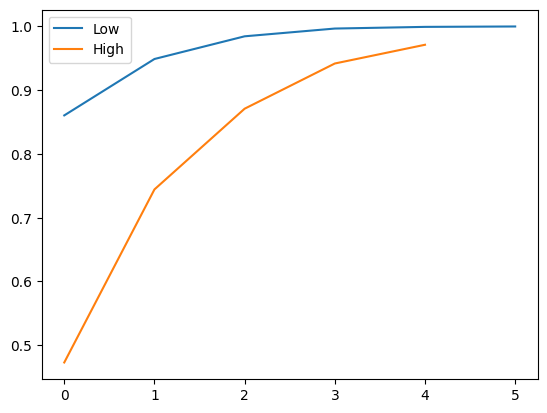

In [9]:
plt.plot(low_ssims, label='Low')
plt.plot(high_ssims, label='High')
plt.legend()
plt.show()

In [18]:
def to_plt_plot(image_tensor):
    import matplotlib.pyplot as plt

    # Step 1: 移除 batch 维度 -> (3, H, W)
    image = image_tensor.squeeze(0)

    # Step 2: 转换为 (H, W, 3) 的 numpy 数组
    image = image.permute(1, 2, 0).cpu().numpy()

    # Step 4: 显示图像
    plt.imshow(image, cmap="rainbow")
    plt.axis('off')  # 不显示坐标轴
    plt.show()

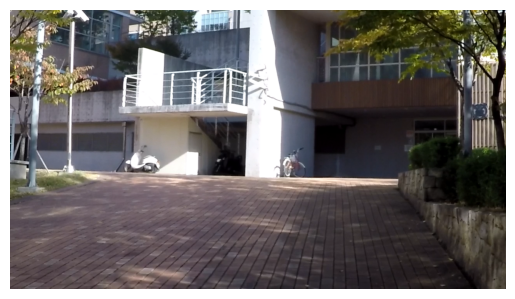

In [19]:
to_plt_plot(target)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


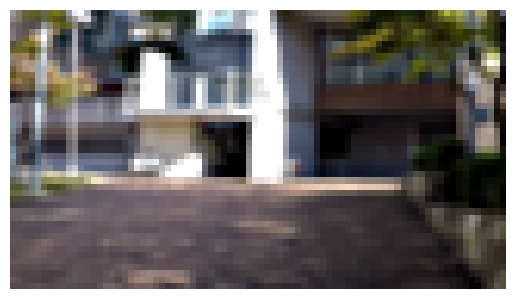

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


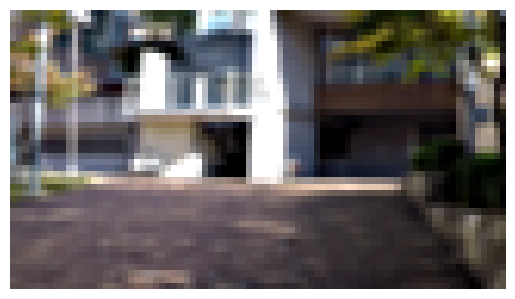

In [21]:
to_plt_plot(gt_lp[-2][1] + gt_lp[-2][0])
to_plt_plot(in_lp[-2][1] + in_lp[-2][0])


In [8]:
pred = LP(in_lp[:-2] + [gt_lp[-2], in_lp[-1]])

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 45 but got size 46 for tensor number 1 in the list.

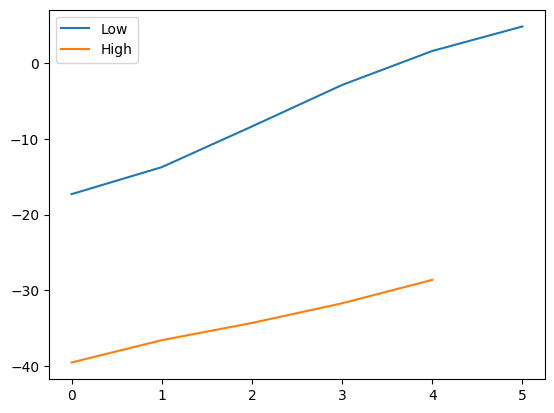

In [63]:
plt.plot(low_psnrs, label='Low')
plt.plot(high_psnrs, label='High')
plt.legend()
plt.show()

In [60]:
pred_img = to_pil_img(pred)
ssim = compare_ssim(pred_img, to_pil_img(target), multichannel=True, channel_axis=2, data_range=1)
psnr = compare_psnr(pred_img, to_pil_img(target), data_range=1)
ssim, psnr

(0.849463, -20.545670529230332)

In [24]:
pred_gt = LP([ i[0] + i[1] for i in in_lp[:-2]] + [gt_lp[-2][0], in_lp[-1]])
ssim = compare_ssim(to_pil_img(pred_gt), to_pil_img(target), multichannel=True, channel_axis=2, data_range=1)
psnr = compare_psnr(to_pil_img(pred_gt), to_pil_img(target), data_range=1)
ssim, psnr

(0.20889972, -39.90053742891119)

In [28]:
torch.max(in_lp[-2][1])

tensor(0.9999)

In [29]:
torch.min(in_lp[-2][1])

tensor(5.6088e-05)

In [30]:
(in_lp[-2][1].shape[2:])

torch.Size([45, 80])

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
conv_freqs = nn.ModuleList(
    [nn.Conv2d(3, 16, 3, 1, 1) for _ in range(5)]
)

In [34]:
conv_freqs[-1](in_lp[-1]).shape

torch.Size([1, 16, 23, 40])